# Notebook 10 - Multiclass Classification

__[Example Notebook]__

Note: the techniques I'm using to prepare the data aren't best practices, like:

- using max-scaling to normalize data
- the way I train test split
- not shuffling the test data

I'm just using quick and easy ways to prepare this data for use in the model, our goal here is just to showcase a working neural network :)

In [ ]:
def as_onehot(y_pred: list):
    max_pred = max(y_pred)
    return [1 if x == max_pred else 0 for x in y_pred]


In [24]:
import kaitorch

from kaitorch.models import Sequential
from kaitorch.layers import Dense, Dropout
from kaitorch.optimizers import SGD, Momentum, Nesterov
from kaitorch.losses import CategoricalCrossentropy
from kaitorch.graph import plot_model

from kaitorch.utils import as_onehot

#### Loading the Iris Dataset

In [25]:
from sklearn.datasets import load_iris
data = load_iris()

Imports for graphing, the Iris dataset has 4 input features and we can only visualize using 2 dimensions so we perform dimensionality reduction using PCA.

In [26]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from sklearn.decomposition import PCA

__Plotting the data__

In [27]:
def plot_iris(data): 

    X_pca = PCA(n_components=2).fit_transform(data.data)
    y = data.target

    plt.figure(figsize=(10,8))
    hot = plt.get_cmap('hot')
    cNorm  = colors.Normalize(vmin=0, vmax=len(data.target_names))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

    for i in range(len(data.target_names)):
        s, e = i*50, (i+1)*50
        plt.scatter(
            X_pca[s:e, 0],
            X_pca[s:e, 1],
            s=50,
            color=scalarMap.to_rgba(i),
            label=data.target_names[i])

    plt.title("Iris Dataset after PCA (n_components=2)")
    plt.xlabel("1st eigenvector")
    plt.ylabel("2nd eigenvector")
    plt.legend(loc='lower right')

    plt.show()

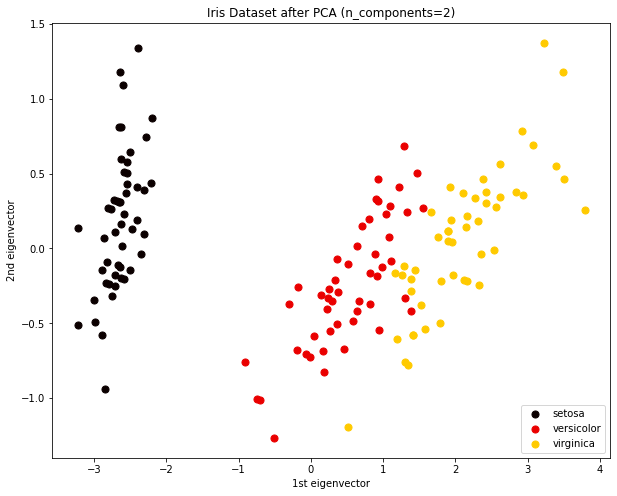

In [28]:
plot_iris(data)

__Making things easier for ourselves:__

For the purposes of demonstration and keeping runtimes low, I'm going to scale the features of Virginica to be more separable from versicolor. 

Of course, we don't have to do this but as you probably know by now our neural network is very slow as its built using only built-in python libraries and operates on scalar values. Feel free to leave it as is and increase the network size/epochs though - should still work.

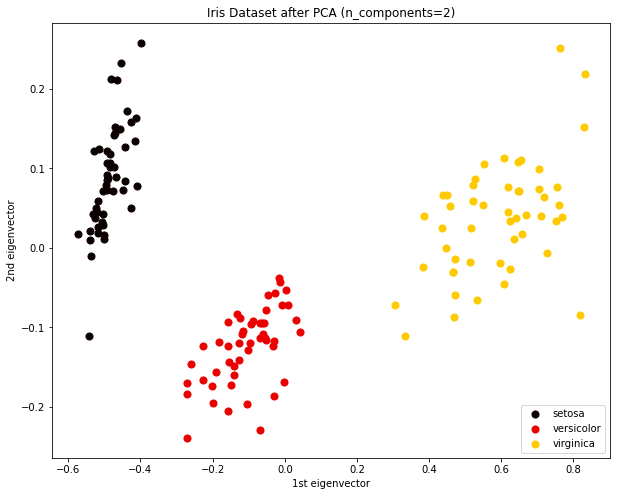

In [74]:
data['data'][-50:] = data['data'][-50:] * 1.2
data['data'] = data['data']/data['data'].max(axis=0)
plot_iris(data)

__One-hot encoding__

Because our labels are in the form of single integers, but our output will be the output of 3 nodes, each representing one class, we need to one-hot encode our data.

In [31]:
oh_map = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1]
}
data['target'] = list(map(oh_map.get, data['target']))

__Train/Test split__

In [43]:
X_train = list(data['data'][:40]) + list(data['data'][50:90]) + list(data['data'][100:140])
y_train = list(data['target'][:40]) + list(data['target'][50:90]) + list(data['target'][100:140])

X_test = list(data['data'][40:50]) + list(data['data'][90:100]) + list(data['data'][140:150])
y_test = list(data['target'][40:50]) + list(data['target'][90:100]) + list(data['target'][140:150])

__Shuffle training data__

In [44]:
import random

shuffled_order = list(range(len(X_train)))
random.shuffle(shuffled_order)

X_train = [X_train[i] for i in shuffled_order]
y_train = [y_train[i] for i in shuffled_order]

__Building our model__

Let's try making a network with 3 hidden Dense layers with 16 units each. Each one using a `ReLU` activation and `he_normal` initializer (a commonly used pairing, probably moreso than `sigmoid`/`glorot_uniform` due to the simplicity of `ReLU`). Let's also use a 0.25 dropout between each hidden layer.

Since we are performing multiclass classification with 3 classes, we'll use a Dense output layer with 3 units and a `softmax` activation, so that the final values have the convenient property of adding up to 1.

Lastly, we'll compile it with a `Momentum` optimizer and `CategoricalCrossentropy` loss function.

In [76]:
model = Sequential()

model.add(Dense(16, activation='ReLU', initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='ReLU', initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='ReLU', initializer='he_normal'))
model.add(Dense(3, activation='softmax'))

model.compile(
    optimizer=kaitorch.optimizers.Momentum(lr=0.025, momentum=0.8),
    loss=kaitorch.losses.CategoricalCrossentropy()
)

In [77]:
model.build(input_size=4)
model.summary()

___________________________________________________________________________________________________________________
Layer (params)                                                      Output Shape       Params = Weights + Biases
Dense(units=16, activation=ReLU, initializer=he_normal)             (None, 16)         80       64        16    
___________________________________________________________________________________________________________________
Dropout(dropout_rate=0.25)                                          (None, 16)         0        0         0     
___________________________________________________________________________________________________________________
Dense(units=16, activation=ReLU, initializer=he_normal)             (None, 16)         272      256       16    
___________________________________________________________________________________________________________________
Dropout(dropout_rate=0.25)                                          (None, 16)      

__Training our model__

In [38]:
%%time
history = model.fit(X_train, y_train, epochs=32)

Epoch  32/32: 100%|████████████████████████████████████████| 120/120 [00:03<00:00, Train Loss: 1.2043]


CPU times: user 1min 42s, sys: 2.47 s, total: 1min 45s
Wall time: 1min 49s


__Evaluating our model__

In [67]:
y_pred = model.predict(X_test)
y_pred = [as_onehot(row) for row in y_pred]

Epoch   1/1: 100%|████████████████████████████████████████| 30/30 [00:00<00:00, Eval]


In [70]:
def print_accuracy(y_test, y_pred):
    
    matches = [test == pred for test, pred in zip(y_test, y_pred)]
    
    accuracy_dec = sum(matches)/len(matches)
    
    accuracy_pct = f'{100*accuracy_dec:.4}%'

    print(f'Accuracy: {accuracy_pct}')

In [71]:
print_accuracy(y_test, y_pred)

Accuracy: 96.67%


__Model Visualization__

If you'd like to see all the gradients flowing through the model, adjust the `fit()` function in `models.py` to return `y_pred` and run `plot_model()` on it. Here all our gradients are zeroed out because we aren't training the model - we're are only doing a forward pass, no backprop.

In [79]:
y_pred = model.predict(X_test, as_scalar=True)
plot_model(y_pred[0])

Epoch   1/1: 100%|████████████████████████████████████████| 30/30 [00:00<00:00, Eval]
